In [1]:
import mtcnn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/0 (e.g. pd. read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
import pickle
import os
print (os.listdir("lfw_mixed"))


['test', 'train']


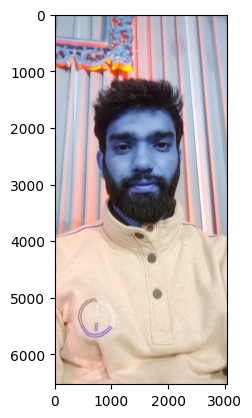

(6528, 3040, 3)


In [2]:
img = cv2.imread('lfw_mixed/test/mayank/mayank.jpg')
#img = cv2.imread('../input/lfwmasked/lfw_masked/Train/Vladimir Putin/Vladimir Putin_0040.jpg')
plt. imshow(img, cmap = 'gray', interpolation = 'bicubic')
#plt.xticks ([]), plt.yticks ([]) # to hide tick values on X and Y axis
plt.show()
print (img.shape)


1/1 [==============================] - 0s 169ms/step
[{'box': [154, 108, 186, 257], 'confidence': 0.9998726844787598, 'keypoints': {'left_eye': (202, 207), 'right_eye': (298, 201), 'nose': (251, 255), 'mouth_left': (216, 310), 'mouth_right': (292, 306)}}]


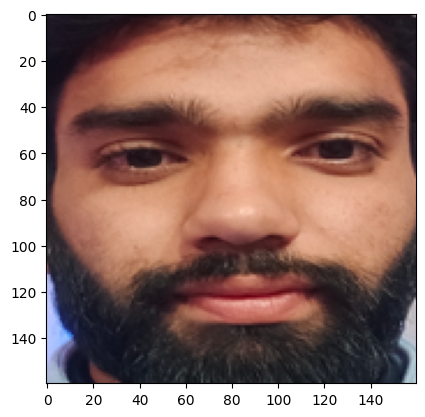

(160, 160, 3)


In [32]:


def extract_face(filename, required_size=(160, 160)):
    #load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    
    #convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN ()
    # detect faces in the image
    results = detector.detect_faces (pixels)
    # extract the bounding box from the first face
    #print (type (results))
    print (results)
    if results:
        x1, y1, width, height = results [0] ['box']
    else:
        x1, y1, width, height = [0, 0, image.width  , image.height]
    # deal with negative pixel index
    x1, y1= abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels [y1:y2, x1:x2]
    # resize pixels to the model size
    image= Image.fromarray(face)
    image = image. resize(required_size)
    face_array = np.asarray(image)
    return face_array




#load the photo and extract the face
pixels = extract_face("lfw_mixed/train/mayank.png")
#pixels = extract_face('../input/lfw-masked/lfw_masked/Train/Vladimir Putin/Vladimir Putin_0040.jpg')
plt.imshow(pixels)
plt.show()
print (pixels.shape)





In [33]:

def load_face (dir):
    faces= list ()
    # enumerate files
    for filename in os. listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces


In [43]:
def load_dataset (dir):
    # list for faces and labels
    X, y =list(), list()
    
    faces= load_face(dir)
    labels= [subdir for i in range (len (faces))]
    print("loaded %d sample for class: %s" % (len (faces), subdir) ) # print progress
    X. extend (faces)
    y.extend (labels)
    return np.asarray(X), np.asarray(y)




In [44]:
#load train dataset
trainx, trainy = load_dataset('lfw_mixed/train/')
print (trainX. shape, trainy.shape)
#load test dataset
testX, testy = load_dataset('lfw_mixed/test/')
print(testX.shape, testy.shape)
#save and compress the dataset for further use
np. savez_compressed ('lfw_masked1.npz', trainX, trainy, testX, testy)

data = np.load('lfw_masked.npz')
trainx, trainy, testX, testy = data['arr_0'], data ['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX. shape, trainy.shape, testX.shape, testy. shape)

facenet_model = load_model('facenet-keras/facenet_keras.h5')
print('Loaded Model')


1/1 [==============================] - 0s 169ms/step
[{'box': [154, 108, 186, 257], 'confidence': 0.9998726844787598, 'keypoints': {'left_eye': (202, 207), 'right_eye': (298, 201), 'nose': (251, 255), 'mouth_left': (216, 310), 'mouth_right': (292, 306)}}]
1/1 [==============================] - 0s 178ms/step
[{'box': [96, 107, 301, 392], 'confidence': 0.999995231628418, 'keypoints': {'left_eye': (189, 266), 'right_eye': (326, 248), 'nose': (270, 339), 'mouth_left': (208, 400), 'mouth_right': (342, 381)}}]
1/1 [==============================] - 0s 176ms/step
[]
3/3 [==============================] - 0s 56ms/step
[{'box': [5689, 498, 235, 238], 'confidence': 0.9404788017272949, 'keypoints': {'left_eye': (5777, 620), 'right_eye': (5839, 572), 'nose': (5838, 649), 'mouth_left': (5826, 677), 'mouth_right': (5880, 640)}}, {'box': [5527, 2072, 136, 169], 'confidence': 0.8031793236732483, 'keypoints': {'left_eye': (5572, 2147), 'right_eye': (5616, 2136), 'nose': (5598, 2180), 'mouth_left': (558

NameError: name 'subdir' is not defined

In [ ]:

def get_embedding (model, face):
    # scale pixel values
    face =face.astype('float32')
    # standardization
    mean, std =face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims (face, axis=0)
    # make prediction to get embedding
    yhat= model.predict (sample)
    return yhat [0]



In [ ]:

emdTrainX= list()
for face in trainX:
    emd = get_embedding (facenet_model, face)
    emdTrainx.append(emd)

emdTrainX = np.asarray(emdTrainX)
print (emdTrainX. shape)
#convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding (facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print (emdTestX.shape)
#save arrays to one file in compressed format
np. savez_compressed( 'lfw_masked1.npz', emdTrainx, trainy, emdTestX, testy)



In [ ]:

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
print("Dataset: train=%d, test=%d" % (emdTrainX. shape [0], emdTestX.shape [0]))
#normalize input vectors
in_encoder= Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
#label encode targets
out_encoder=LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
#fit model
model = SVC (kernel='linear', probability=True)
model. fit (emdTrainX_norm, trainy_enc)


In [ ]:

with open('mymodel.pkl', 'wb') as f:
    pickle.dump(model, f)
# predict
yhat_train= model.predict (emdTrainX_norm)
yhat_test= model.predict (emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test= accuracy_score (testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))



In [ ]:

from random import choice
# select a random face from test set
selection = choice ([i for i in range (testX.shape [0])])
random_face = testX [selection]
random_face_emd = emdTestX_norm [selection]
random_face_class = testy_enc [selection]
random_face_name = out_encoder.inverse_transform( [random_face_class])



In [ ]:

# prediction for the face
print (type(random_face_emd))
print (random_face_emd. shape)
samples = np.expand_dims (random_face_emd, axis=0)
print (samples.shape)
yhat_class= model.predict (samples)
yhat_prob = model.predict_proba (samples)
# get name
class_index = yhat_class [0]
class_probability = yhat_prob [0, class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names =out_encoder.inverse_transform ( [0,1,2,3,4])
#print('Predicted: %s (%.3f) % (predict_names [0], class_probability))
print('Predicted: \n%s\n%s % (all_names, yhat_prob [0]*100) ')
print('Expected: %s % random_face_name [0]')
#plot face
plt. imshow(random_face)
title = '%s (%.3f)' % (predict_names [0], class_probability)
plt.title(title)
plt.show()


In [ ]:

def get_embedding (model, face):
    #scale pixel values
    face =face.astype('float32')
    #standardization
    mean, std= face.mean(), face.std()
    face= (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample= np.expand_dims (face, axis=0)
    #make prediction to get embedding
    yhat =model.predict (sample)
    return yhat [0]


In [ ]:


from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
#from random import choice
#select a random face from test set
# normalize input vectors
in_encoder= Normalizer()
#label encode targets
out_encoder=LabelEncoder ()
out_encoder.fit (trainy)
random_face= extract_face('lfw_mixed/test/Vladimir Putin/12.jpg')
#random_face = extract_face ('lfw_mixed/test/Bill_Clinton/5.jpg')
#random_face = extract_face ('l fw_mixed/test/Tony Blair/24.jpg')
#random_face = extract_face('/Users/swati/data_split/lfw_masked_mixed/Queen_Elizabeth II/Queen_Elizabeth_II_0003.jpg
#random_face = extract_face('/Users/swati/data_split/lfw_masked_mixed/Queen_Elizabeth II/Queen Elizabeth_II_0009.jpg
emdFace = get_embedding (facenet_model, random_face)
emdFace= emdFace. reshape (1,-1)
random_face_emd = in_encoder.transform(emdFace)


In [ ]:

# and later you can load it
with open('mymodel.pkl', 'rb') as f:
    mymodel =pickle.load(f)
# prediction for the face
samples =random_face_emd
yhat_class= mymodel.predict (samples)
yhat_prob = mymodel.predict_proba (samples)
# get name
class_index=yhat_class [0]
class_probability = yhat_prob [0, class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names =out_encoder. inverse_transform(np.arange (len (yhat_prob [0])))



In [ ]:

i=0
for name in all_names:
    print (name, yhat_prob [0] [i]*100)
i = i +1
#plot face
plt. imshow(random_face)
if(class_probability<40):
    #print("insideif")
    title= 'Unknown Face'
else:
    #print("insideelse")
    title= '%s (%.3f)' % (predict_names [0], class_probability)
#title = '%s (%.3f) % (predict_names [0], class_probability)
plt.title(title)
plt.show()


